In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import sys
from pathlib import Path

# Ensure src is in the Python path
try:
    ROOT = Path(__file__).resolve().parent.parent
except NameError:
    ROOT = Path().resolve().parent
sys.path.append(str(ROOT))

from src.config import DATA_RAW, DATA_PROCESSED, OUTPUT_PLOTS
from src.data_loader import load_all_csv
from src.preprocessing import preprocess
from src.tags import tag_events, tag_frequencies
from src.anomaly_detection import detect_anomalies, tag_anomalies
from src.plotting import plot_time_with_events, plot_tag_anomalies, plot_time_with_unplugged_events, plot_time_with_state_bands, plot_time_with_tag_markers, plot_anomalies
pd.set_option("display.max_columns", None)

# Load Data/data_loader

In [2]:
df = load_all_csv()
df.head()

Combined data saved to ..\data\processed\merged_all_raw_data.csv


,date,time,ion_analog,voltage_ion,pressure_ion,conv_analog,voltage_conv,pressure_conv,tags
0,2025-06-23,14:06:02,444.0,2.19,2.440000e-07,193.0,0.954,0.00101,"IG on, CG on"
1,2025-06-23,14:06:03,445.0,2.20,2.500000e-07,194.0,0.959,0.00103,"IG on, CG on"
2,2025-06-23,14:06:04,444.0,2.19,2.440000e-07,194.0,0.959,0.00103,"IG on, CG on"
3,2025-06-23,14:06:05,445.0,2.20,2.500000e-07,194.0,0.959,0.00103,"IG on, CG on"
4,2025-06-23,14:06:06,444.0,2.19,2.440000e-07,193.0,0.954,0.00101,"IG on, CG on"


# Clean data/preprocessing

In [3]:
# drops unnecessary columns like analog and merges date and time to datetime column
df_cleaned_engineered = preprocess(df)
df_cleaned_engineered.head()

,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,tags,delta_ion,delta_conv,log_pressure_ion,log_pressure_conv,delta_log_ion,delta_log_conv,roll3_mean_ion,roll3_std_ion,roll3_min_ion,roll3_max_ion,roll7_mean_ion,roll7_std_ion,roll7_min_ion,roll7_max_ion,roll3_mean_conv,roll3_std_conv,roll3_min_conv,roll3_max_conv,roll7_mean_conv,roll7_std_conv,roll7_min_conv,roll7_max_conv,slope_ion,slope_conv
0,2025-06-23 14:06:02,2.19,2.440000e-07,0.954,0.00101,"IG on, CG on",NaN,NaN,-15.226098,-6.897805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-06-23 14:06:03,2.20,2.500000e-07,0.959,0.00103,"IG on, CG on",6.000000e-09,0.00002,-15.201805,-6.878196,0.024293,0.019608,2.470000e-07,3.000000e-09,2.440000e-07,2.500000e-07,NaN,NaN,NaN,NaN,0.001020,0.000010,0.00101,0.00103,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-06-23 14:06:04,2.19,2.440000e-07,0.959,0.00103,"IG on, CG on",-6.000000e-09,0.00000,-15.226098,-6.878196,-0.024293,0.000000,2.460000e-07,2.828427e-09,2.440000e-07,2.500000e-07,2.460000e-07,2.828427e-09,2.440000e-07,2.500000e-07,0.001023,0.000009,0.00101,0.00103,0.001023,0.000009,0.00101,0.00103,NaN,NaN
3,2025-06-23 14:06:05,2.20,2.500000e-07,0.959,0.00103,"IG on, CG on",6.000000e-09,0.00000,-15.201805,-6.878196,0.024293,0.000000,2.480000e-07,2.828427e-09,2.440000e-07,2.500000e-07,2.470000e-07,3.000000e-09,2.440000e-07,2.500000e-07,0.001030,0.000000,0.00103,0.00103,0.001025,0.000009,0.00101,0.00103,NaN,NaN
4,2025-06-23 14:06:06,2.19,2.440000e-07,0.954,0.00101,"IG on, CG on",-6.000000e-09,-0.00002,-15.226098,-6.897805,-0.024293,-0.019608,2.460000e-07,2.828427e-09,2.440000e-07,2.500000e-07,2.464000e-07,2.939388e-09,2.440000e-07,2.500000e-07,0.001023,0.000009,0.00101,0.00103,0.001022,0.000010,0.00101,0.00103,0.0,0.0


In [4]:
df_cleaned_engineered.isnull().sum()
df_cleaned_engineered["IC_unplugged"]= df_cleaned_engineered[["voltage_ion", "pressure_ion"]].isna().all(axis=1)
df_cleaned_engineered["CC_unplugged"]= df_cleaned_engineered[["voltage_conv", "pressure_conv"]].isna().all(axis=1)

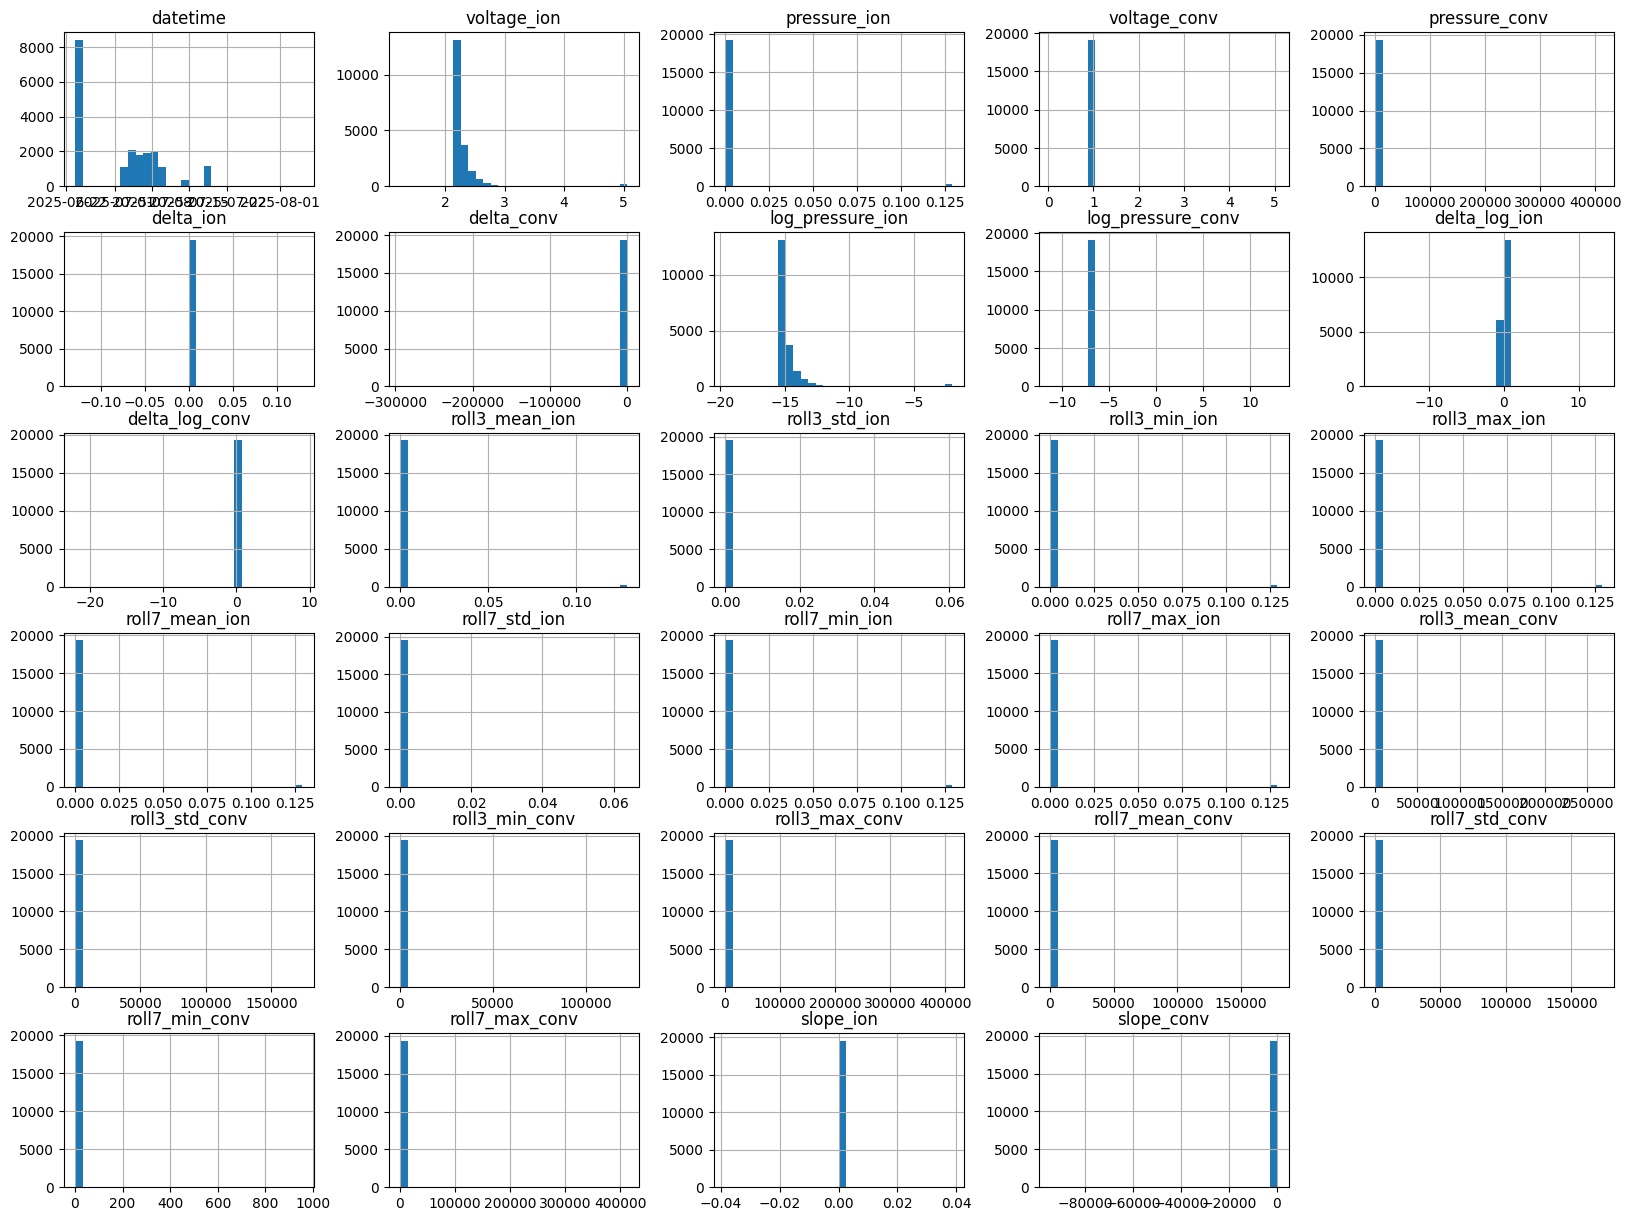

In [5]:
df_cleaned_engineered.hist(bins=30, figsize=(20,15))
plt.show()

<Axes: >

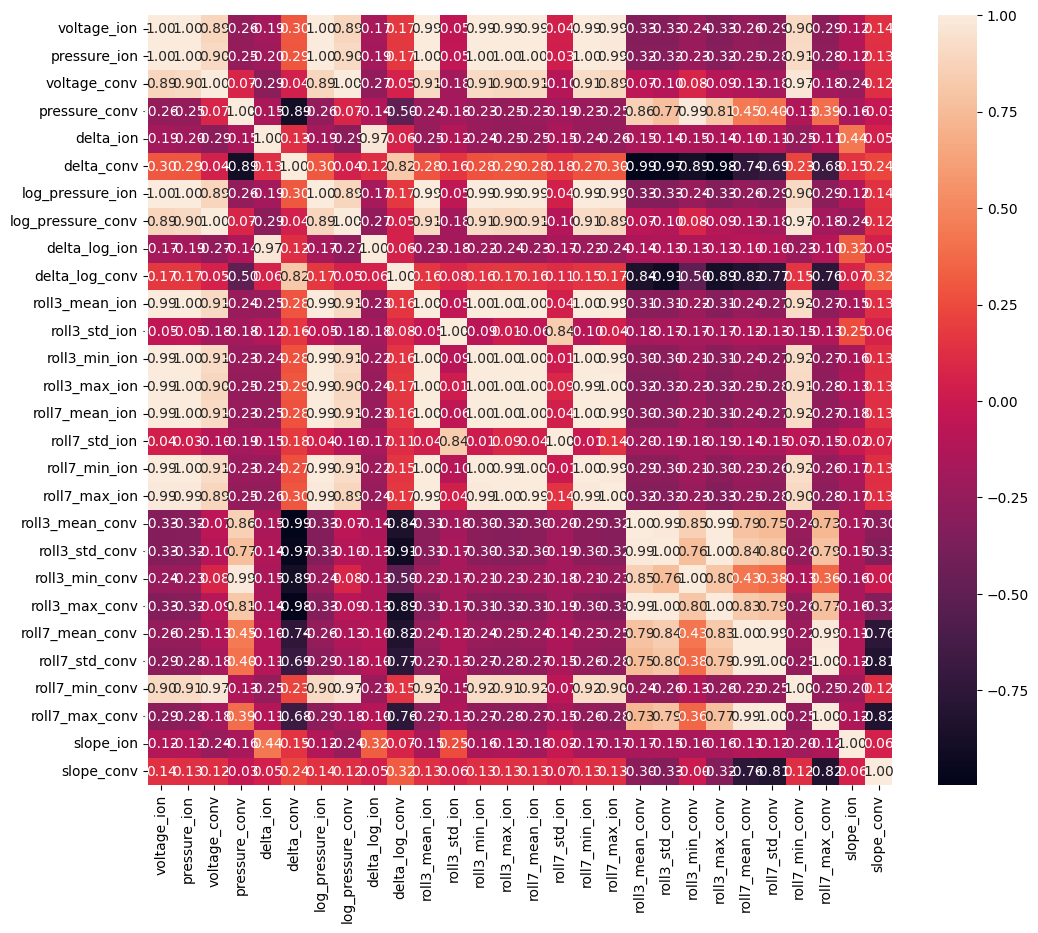

In [6]:
import seaborn as sns
df_heatmap = df_cleaned_engineered.select_dtypes(include='number').corr()
plt.figure(figsize=(12, 10))
sns.heatmap(df_heatmap.corr(), annot=True, fmt=".2f")

# Tags analysis

Create binary columns for key tag types

In [7]:
# Parse tags into list
#  Add binary columns for using MultiLabelBinarizer from sklearn
# Derive IG_state & CG_state

df_tags = tag_events(df_cleaned_engineered)

# Summary tag frequencies

In [8]:
# Tag frequencies
print("Tag Frequencies:\n", tag_frequencies(df_tags))

Tag Frequencies:
                   Tag  Count
0               CG on  19374
1               IG on  19276
2              IG off    719
3              CG off    658
4             venting    136
5               RP on    120
6   gate manipulation     64
7          IG turn on     27
8          IG slow on     18
9          CG turn on     12
10       chamber open     11
11        IG turn off     10
12        CG turn off      5
13            IG fail      5


# Detect anomalies

In [9]:
pd.set_option("display.max_columns", None)
df_altered = detect_anomalies(df_tags)
df_anomalies_ion = df_altered[df_altered["anomaly_if_ion"] == -1]
df_anomalies_conv = df_altered[df_altered["anomaly_if_conv"] == -1]
df_anomalies_ion.head()

,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,tags,delta_ion,delta_conv,log_pressure_ion,log_pressure_conv,delta_log_ion,delta_log_conv,roll3_mean_ion,roll3_std_ion,roll3_min_ion,roll3_max_ion,roll7_mean_ion,roll7_std_ion,roll7_min_ion,roll7_max_ion,roll3_mean_conv,roll3_std_conv,roll3_min_conv,roll3_max_conv,roll7_mean_conv,roll7_std_conv,roll7_min_conv,roll7_max_conv,slope_ion,slope_conv,IC_unplugged,CC_unplugged,tag_list,tag_IG_on,tag_IG_off,tag_IG_fail,tag_IG_turn_on,tag_IG_turn_off,tag_IG_slow_on,tag_CG_on,tag_CG_off,tag_CG_turn_off,tag_CG_turn_on,tag_gate_manipulation,tag_RP_on,tag_chamber_open,tag_venting,IG_state,CG_state,CH_state,anomaly_if_ion,score_if_raw_ion,score_if_ion,anomaly_if_conv,score_if_raw_conv,score_if_conv,anomaly_if,score_if_raw,score_if
96,2025-06-23 14:29:52,5.06,1.290000e-01,0.954,0.00101,"IG turn off, CG on",0.129000,0.00000,-2.047943,-6.897805,13.178155,0.000000,0.043000,0.060811,2.440000e-07,0.129000,0.018429,0.045141,2.440000e-07,0.129000,0.001001,0.000013,0.000983,0.00101,0.000998,0.000013,0.000983,0.00101,0.025800,0.000005,False,False,"[IG turn off, CG on]",0,0,0,0,1,0,1,0,0,0,0,0,0,0,IG turn off,CG on,CH normal,-1,-0.087140,0.087140,1,0.318590,-0.318590,-1,-0.087140,0.087140
125,2025-06-23 14:35:48,5.06,1.290000e-01,0.954,0.00101,"IG turn off, CG on",0.129000,0.00000,-2.047943,-6.897805,13.178155,0.000000,0.043000,0.060811,2.440000e-07,0.129000,0.018429,0.045141,2.440000e-07,0.129000,0.001010,0.000000,0.001010,0.00101,0.001002,0.000012,0.000983,0.00101,0.025800,0.000005,False,False,"[IG turn off, CG on]",0,0,0,0,1,0,1,0,0,0,0,0,0,0,IG turn off,CG on,CH normal,-1,-0.087140,0.087140,1,0.318590,-0.318590,-1,-0.087140,0.087140
126,2025-06-23 14:35:50,1.30,4.060000e-09,0.954,0.00101,"IG turn on, CG on",-0.129000,0.00000,-19.322083,-6.897805,-17.274140,0.000000,0.043000,0.060811,4.060000e-09,0.129000,0.018429,0.045141,4.060000e-09,0.129000,0.001010,0.000000,0.001010,0.00101,0.001006,0.000009,0.000983,0.00101,0.012900,0.000000,False,False,"[IG turn on, CG on]",0,0,0,1,0,0,1,0,0,0,0,0,0,0,IG turn on,CG on,CH normal,-1,-0.008262,0.008262,1,0.338432,-0.338432,-1,-0.008262,0.008262
216,2025-06-23 15:36:35,3.07,1.400000e-05,0.969,0.00108,"IG on, CG on, venting",0.000012,0.00005,-11.176453,-6.830794,1.726775,0.047402,0.000006,0.000005,2.270000e-06,0.000014,0.000004,0.000004,1.940000e-06,0.000014,0.001047,0.000024,0.001030,0.00108,0.001037,0.000017,0.001030,0.00108,0.000002,0.000010,False,False,"[IG on, CG on, venting]",1,0,0,0,0,0,1,0,0,0,0,0,0,1,IG on,CG on,venting,-1,-0.041459,0.041459,1,0.085458,-0.085458,-1,-0.041459,0.041459
217,2025-06-23 15:36:36,3.32,4.280000e-05,0.969,0.00108,"IG on, CG on, venting",0.000029,0.00000,-10.058972,-6.830794,1.117481,0.000000,0.000020,0.000017,2.490000e-06,0.000043,0.000010,0.000014,1.980000e-06,0.000043,0.001063,0.000024,0.001030,0.00108,0.001044,0.000023,0.001030,0.00108,0.000009,0.000015,False,False,"[IG on, CG on, venting]",1,0,0,0,0,0,1,0,0,0,0,0,0,1,IG on,CG on,venting,-1,-0.043057,0.043057,1,0.170769,-0.170769,-1,-0.043057,0.043057


In [10]:
df_altered[df_altered['anomaly_if'] == -1].describe()

,datetime,voltage_ion,pressure_ion,voltage_conv,pressure_conv,delta_ion,delta_conv,log_pressure_ion,log_pressure_conv,delta_log_ion,delta_log_conv,roll3_mean_ion,roll3_std_ion,roll3_min_ion,roll3_max_ion,roll7_mean_ion,roll7_std_ion,roll7_min_ion,roll7_max_ion,roll3_mean_conv,roll3_std_conv,roll3_min_conv,roll3_max_conv,roll7_mean_conv,roll7_std_conv,roll7_min_conv,roll7_max_conv,slope_ion,slope_conv,tag_IG_on,tag_IG_off,tag_IG_fail,tag_IG_turn_on,tag_IG_turn_off,tag_IG_slow_on,tag_CG_on,tag_CG_off,tag_CG_turn_off,tag_CG_turn_on,tag_gate_manipulation,tag_RP_on,tag_chamber_open,tag_venting,anomaly_if_ion,score_if_raw_ion,score_if_ion,anomaly_if_conv,score_if_raw_conv,score_if_conv,anomaly_if,score_if_raw,score_if
count,213,210.000000,2.100000e+02,213.000000,213.000000,210.000000,207.000000,210.000000,213.000000,210.000000,207.000000,2.100000e+02,210.000000,2.100000e+02,2.100000e+02,2.110000e+02,211.000000,2.110000e+02,2.110000e+02,209.000000,209.000000,209.000000,209.000000,206.000000,206.000000,206.000000,206.000000,210.000000,199.000000,213.000000,213.000000,213.0,213.000000,213.000000,213.000000,213.000000,213.0,213.000000,213.000000,213.0,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.0,213.000000,213.000000
mean,2025-06-27 15:35:37.521126912,4.594524,1.075006e-01,2.894955,10232.938425,0.000614,-6545.893492,-4.186653,2.488236,0.077815,-0.298356,1.066816e-01,0.001737,1.050435e-01,1.087292e-01,1.048949e-01,0.002165,1.027114e-01,1.082139e-01,7809.166756,4892.145369,2761.984918,13215.334299,3394.575260,3841.801790,441.639990,9999.926431,0.000799,-122.613016,0.150235,0.826291,0.0,0.009390,0.014085,0.004695,0.948357,0.0,0.004695,0.046948,0.0,0.244131,0.051643,0.582160,0.887324,0.049844,-0.049844,-0.887324,-0.065354,0.065354,-1.0,-0.079044,0.079044
min,2025-06-23 14:27:22,1.300000,4.060000e-09,0.039500,0.000012,-0.129000,-294000.000000,-19.322083,-11.322305,-17.274140,-17.990318,1.820000e-07,0.000000,3.020000e-09,1.820000e-07,1.820000e-07,0.000000,3.020000e-09,1.820000e-07,0.000668,0.000000,0.000012,0.001010,0.000864,0.000009,0.000012,0.001010,-0.025799,-24399.998875,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-1.000000,-0.087140,-0.413621,-1.000000,-0.151324,-0.338432,-1.0,-0.151324,0.000148
25%,2025-06-23 15:49:14,5.060000,1.290000e-01,1.380000,0.007850,0.000000,-20.000000,-2.047943,-4.847242,0.000000,-0.023896,1.290000e-01,0.000000,1.290000e-01,1.290000e-01,1.290000e-01,0.000000,1.290000e-01,1.290000e-01,0.007913,0.000374,0.007490,0.008240,0.009365,0.002748,0.006850,0.015527,0.000000,-0.000201,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,-0.111631,0.036413,-1.0,-0.111631,0.041459
50%,2025-06-23 16:24:08,5.060000,1.290000e-01,3.770000,808.000000,0.000000,0.000000,-2.047943,6.694562,0.000000,0.000000,1.290000e-01,0.000000,1.290000e-01,1.290000e-01,1.290000e-01,0.000000,1.290000e-01,1.290000e-01,827.333333,9.428090,513.000000,847.000000,805.214286,11.382048,434.000000,847.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,-0.095046,0.095046,-1.0,-0.095046,0.095046
75%,2025-06-23 17:22:57,5.060000,1.290000e-01,3.800000,955.000000,0.000000,16.500000,-2.047943,6.861711,0.000000,0.023896,1.290000e-01,0.000000,1.290000e-01,1.290000e-01,1.290000e-01,0.000000,1.290000e-01,1.290000e-01,962.666667,10.842304,955.000000,978.000000,964.857143,33.849769,955.000000,978.000000,0.000000,0.000408,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,-0.036413,0.111631,-1.0,-0.041459,0.111631
max,2025-08-03 16:19:18,5.060000,1.290000e-01,5.060000,413000.000000,0.129000,444.600000,-2.047943,12.931203,13.178155,9.005

## stats

In [11]:

print(df_altered[["pressure_ion","pressure_conv"]].describe())
print(df_altered["IG_state"].value_counts())

       pressure_ion  pressure_conv
count  1.957000e+04   19387.000000
mean   1.608804e-03     112.427689
std    1.431444e-02    5622.526377
min    3.020000e-09       0.000012
25%    2.280000e-07       0.001010
50%    2.440000e-07       0.001010
75%    3.760000e-07       0.001030
max    1.290000e-01  413000.000000
IG_state
IG on          19276
IG off           719
IG turn on        27
IG slow on        17
IG turn off        6
IG fail            2
Name: count, dtype: int64


# Plots

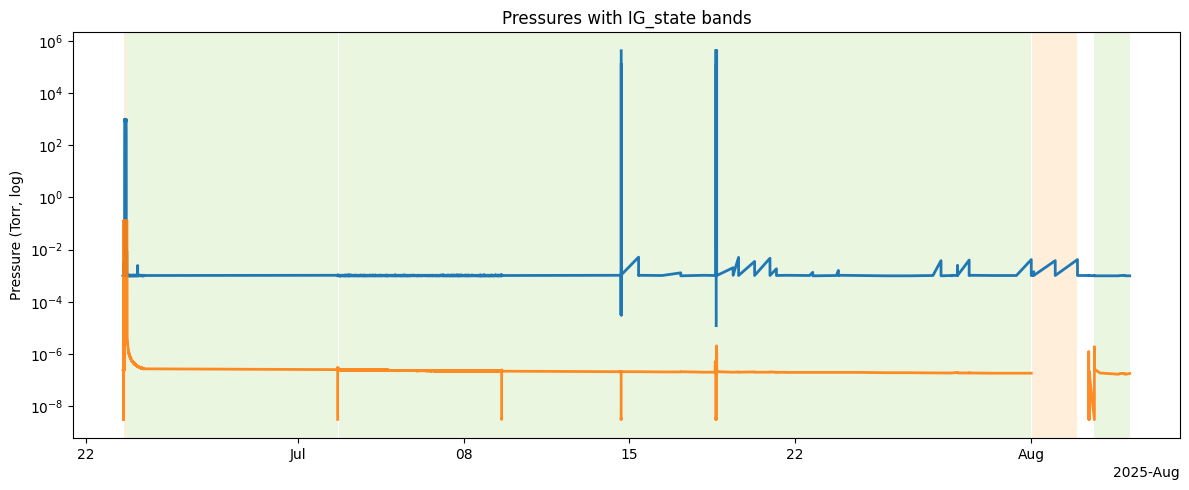

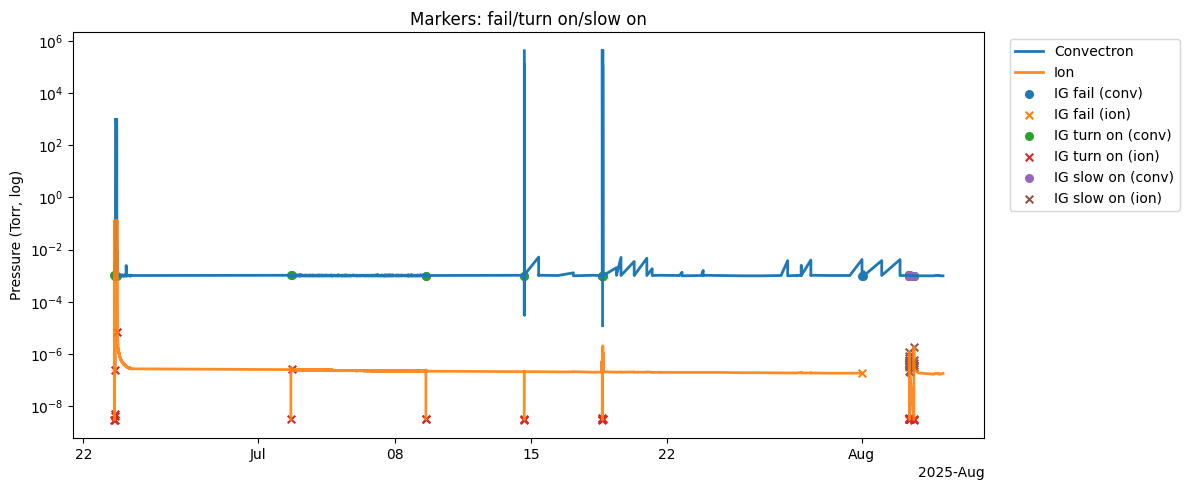

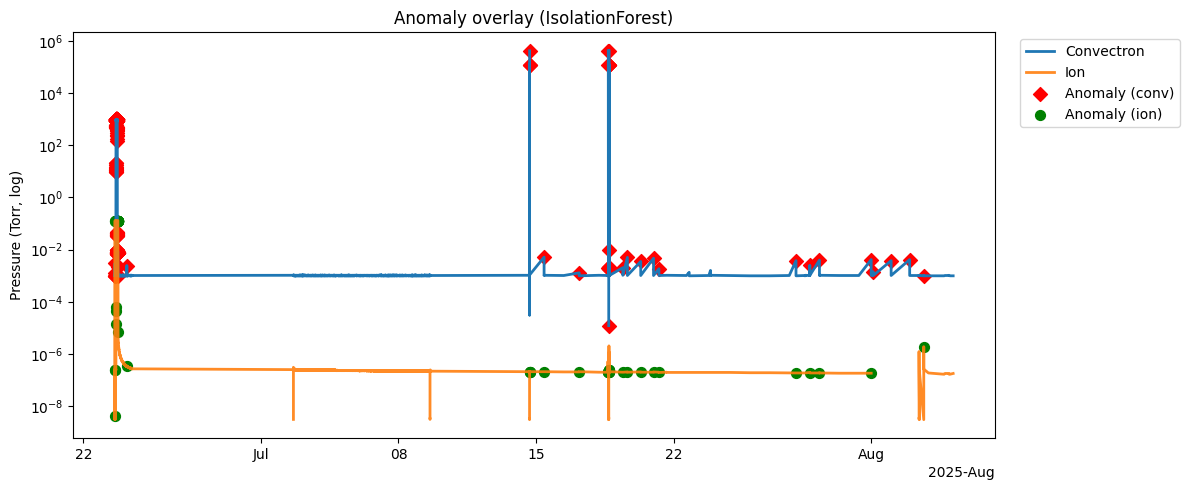

In [12]:

plot_time_with_state_bands(df_altered.reset_index(), title="Pressures with IG_state bands")
df_plot = df_altered.reset_index()
df_plot = df_plot[df_plot["datetime"] <= "2025-06-23 20:00:00"]
plot_time_with_tag_markers(
    df_altered, 
    tags_to_mark=("IG fail", "IG turn on", "IG slow on"),
    title="Markers: fail/turn on/slow on",
    savepath=OUTPUT_PLOTS / "markers_fail_turnon_slowon_eng.png"
)

plot_anomalies(df_altered, title="Anomaly overlay (IsolationForest)", savepath=OUTPUT_PLOTS / "anomalies_overlay_eng.png")


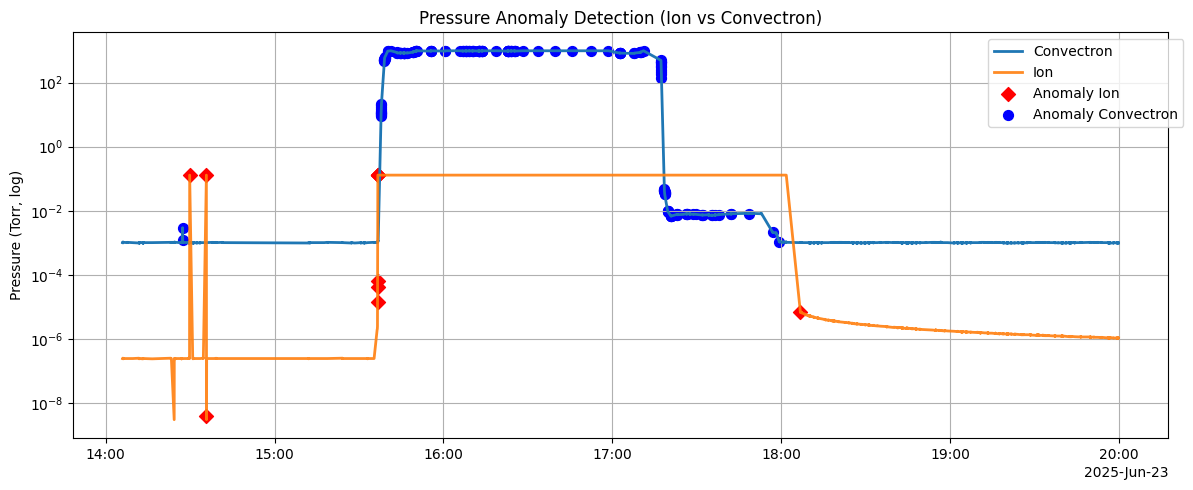

In [15]:
df_feat = tag_anomalies(df_plot)
plot_tag_anomalies(df_feat, title="Pressure Anomaly Detection (Ion vs Convectron)", savepath=OUTPUT_PLOTS / "pressure_anomaly_detection_eng.png")


In [14]:
out = DATA_PROCESSED / "processed_eng.csv"
df_altered.to_csv(out, index=False)
print(f"Saved combined data to {out}")

Saved combined data to ..\data\processed\processed_eng.csv
